In [133]:
#------------------------------------------#
# PHY 152: Assignment 3, Stellar Structure #
#     Bryan J Miller, April 19th, 2016     #
#------------------------------------------#

# load libraries
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

# plot within notebook
%matplotlib inline

# configuration (adjustable)
samples = 100000 # number of steps

X = 0.63 # H abundance by mass
Y = 0.35 # He abundance by mass
Z = 0.02 # metals abundance by mass

gbf = 1.0   # average gaunt factor (bound-free)
gff = 1.89  # average gaunt factor (free-free)
guil = 10.0 # guillotine factor (order of 1-100) numbers under 2 give weird results ???

XH = 0.64    # H abundance for nuclear energy generation rate
Xcno = 0.015 # metals abundance for CNO contributor to energy

gamma = 5.0/3.85 # used in adiabatic convection, dT/dr

# initial conditions (r=0)
Mr0 = 0.1    # [kg]
Lr0 = 0.1    # [W]
T0 = 1.5725E7 # [K]
P0 = 2.3E16  # [N m^-2]

# constants (not adjustable)
mh = 1.6727E-27  # [kg] mass of hydrogen atom
kb = 1.381E-23   # [m^2 kg s^-2 K^-1] Boltzmanm constant
G = 6.67408E-11  # [m^3 kg^-1 s^-2] gravitational constant
r_sun = 6.957E8  # [m] radius of the sun
m_sun = 2.0E30   # [kg] mass of the sun
l_sun = 3.846E26 # [W] luminosity of the sun
a = 7.6565E-16   # [J m^-3 K^-4] radiation constant
c = 2.998E8      # [m s^-1] speed of light
e0pp = 1.08E-12  # [W m^3 kg^-2] p-p chain 
e0cno = 8.24E-31 # [W m^3 kg^-2] CNO reaction

# calculated constants
u = 1.0/((2.0*X)+((3.0/4.0)*Y)+((1.0/2.0)*Z)) # mu, mean molecular weight

# functions

# rho, density
def rho(y):
    Mr, Lr, T, P = y
    rho0 = (P-(a*np.power(T, 4.0)/3.0))*((u*mh)/(kb*T)) # [kg m^-3]
    return rho0

# kappa, opacity
def kappa(y):
    Mr, Lr, T, P = y
    k_bf = 4.3E21*(gbf/guil)*Z*(1.0+X)*(rho(y)/np.power(T, 3.5)) 
    k_ff = 3.7E18*gff*(1.0-Z)*(1.0+X)*(rho(y)/np.power(T, 3.5))    
    k_e = 0.02*(1.0+X)                                       
    kappa0 = ((k_bf+k_ff+k_e)/3.0) # [m^2 kg^-1] average of opacity
    return kappa0

# epsilon, nuclear energy generation rate
def eps(y):
    Mr, Lr, T, P = y                                           
    epp = e0pp*rho(y)*np.power(XH, 2.0)*np.power((T/10E5), 4.0) # p-p chain contribution
    ecno = e0cno*rho(y)*XH*Xcno*np.power((T/10E5), 19.9)        # CNO reaction contribution
    eps0 = epp + ecno                                           # [W m^3 kg^-2] sum for total e generation
    return eps0 

# dM/dr
def dmdr(y, r):
    Mr, Lr, T, P = y
    dmdr0 = 4.0*np.pi*np.power(r, 2.0)*rho(y) # [kg m^-1]
    return dmdr0

# dP/dr
def dpdr(y, r):
    Mr, Lr, T, P = y
    dpdr0 = -G*Mr*rho(y)/np.power(r, 2.0) # [kg m^-2 s^-2]
    return dpdr0

# dL/dr
def dldr(y, r):
    Mr, Lr, T, P = y
    dldr0 = 4.0*np.pi*np.power(r, 2.0)*rho(y)*eps(y) # [W m^-1]
    return dldr0

# dT/dr
def dtdr(y, r):
    Mr, Lr, T, P = y
    dtdr0 = -(3.0/(4.0*a*c))*(kappa(y)*rho(y)/np.power(T, 3.0))*(Lr/(4.0*np.pi*np.power(r, 2.0))) # radiation
    dtdr1 = -(1-(1/gamma))*(u*mh/kb)*(G*Mr/np.power(r, 2.0))                                      # convection
    if r < (0.2*r_sun):
        return dtdr0             # interior temp due to radiation
    elif r > (0.25*r_sun):
        return dtdr1             # outer temp due to adiabatic convection
    else:
        return (dtdr1+dtdr0)/2.0 # average of radiation and adiabatic between 0.2-0.25 R(sun)

# items to pass to odeint()

# system of ODEs to be solved
def main(y, r):
    Mr, Lr, T, P = y
    dr_system = [dmdr(y,r),dldr(y,r),dtdr(y,r),dpdr(y,r)]
    return dr_system

# initial y conditions
y0 = [Mr0, Lr0, T0, P0] 

# define x-axis
r = np.linspace(0.1, r_sun, samples)

# 2D array of solutions, [Mr {kg}, Lr {W}, T {K}, P {N m^2}]
results = odeint(main, y0, r)

# rho array results
rho_results = [[rho(results[y]) for x in range(1)] for y in range(samples)]
rho_array = np.array(rho_results)

# dLdr array results
array_r = np.array(r)
dLdr_results = [[dldr(results[y],array_r[y]) for x in range(1)] for y in range(samples)]
dLdr_array = np.array(dLdr_results)

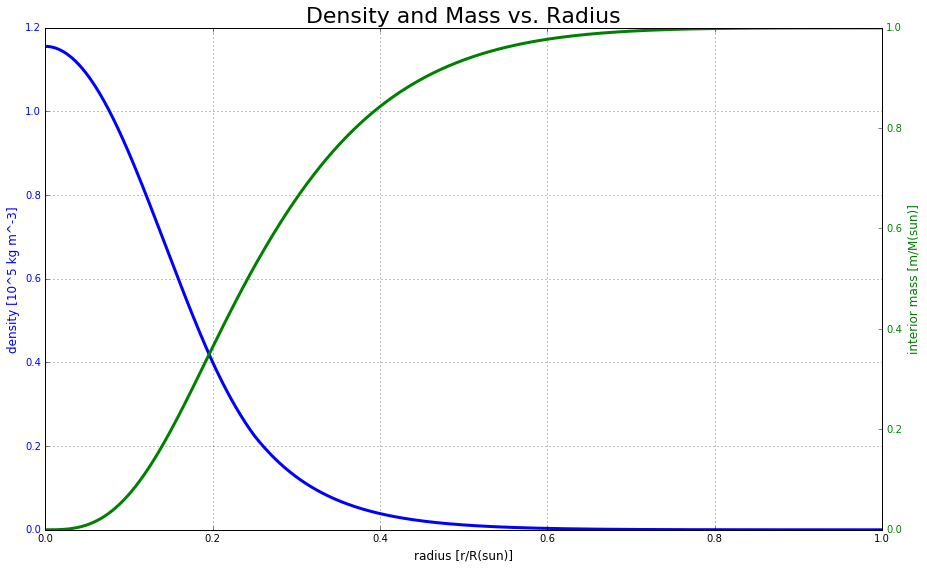

In [134]:
# plot density and mass vs. radius
fig, ax1 = plt.subplots(figsize=(15,9))
plt.grid(True)
plt.title('Density and Mass vs. Radius',fontsize=22)
ax1.plot(r/r_sun, rho_array/10E4, 'b', linewidth=3, label='Density')
ax1.set_xlabel('radius [r/R(sun)]',fontsize=12)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('density [10^5 kg m^-3]', fontsize=12, color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(r/r_sun, results[:, 0]/m_sun, 'g', linewidth=3, label='Mass')
ax2.set_ylabel('interior mass [m/M(sun)]', fontsize=12, color='g')
for tl in ax2.get_yticklabels():
    tl.set_color('g')
plt.show()

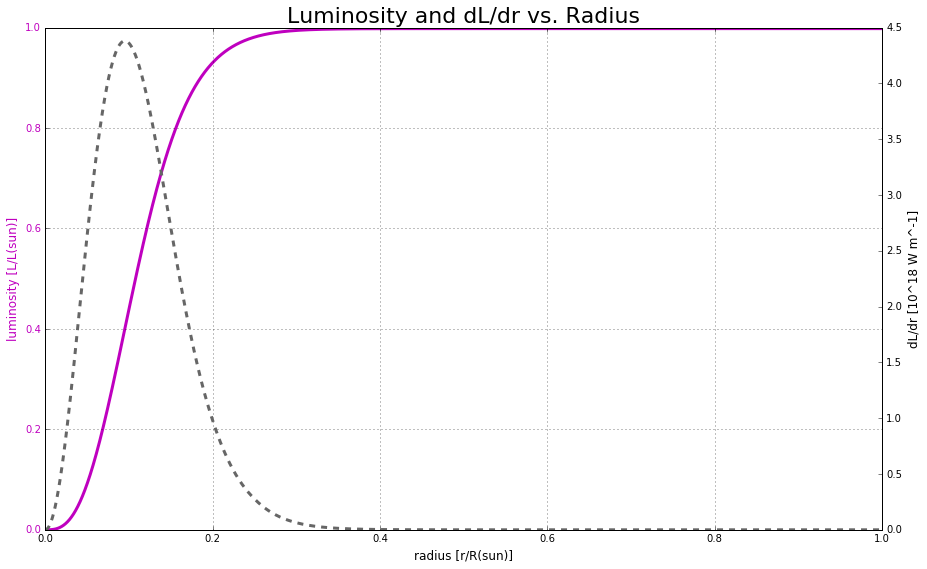

In [135]:
# plot luminosity and dL/dr vs. radius
fig, ax1 = plt.subplots(figsize=(15,9))
plt.grid(True)
plt.title('Luminosity and dL/dr vs. Radius',fontsize=22)
ax1.plot(r/r_sun, 0.571*results[:, 1]/l_sun, 'm', linewidth=3, label='Luminosity')
ax1.set_xlabel('radius [r/R(sun)]',fontsize=12)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('luminosity [L/L(sun)]', fontsize=12, color='m')
for tl in ax1.get_yticklabels():
    tl.set_color('m')

ax2 = ax1.twinx()
ax2.plot(r/r_sun, 0.571*dLdr_array/10E17, '0.4', linestyle='--', linewidth=3, label='dL/dr')
ax2.set_ylabel('dL/dr [10^18 W m^-1]', fontsize=12, color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.show()

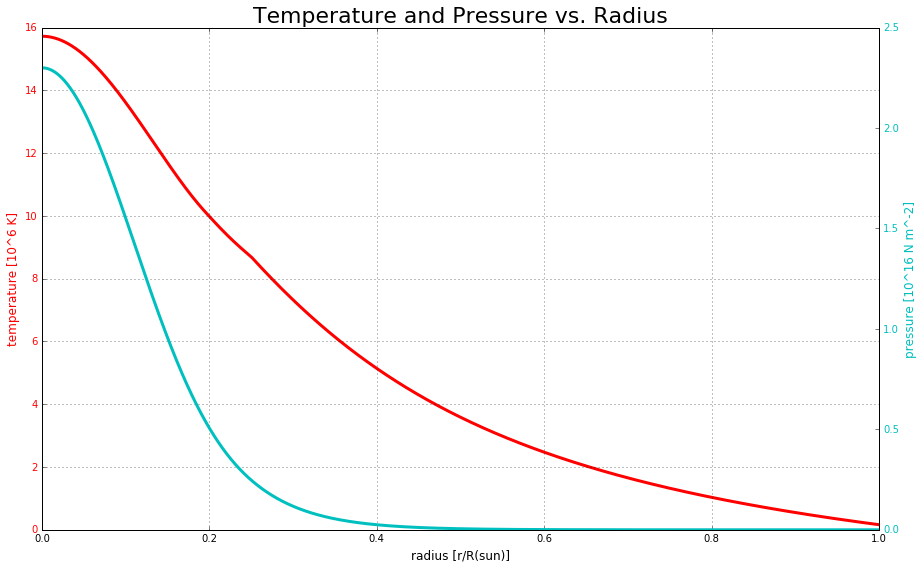

In [136]:
# plot temperature and pressure vs. radius
fig, ax1 = plt.subplots(figsize=(15,9))
plt.grid(True)
plt.title('Temperature and Pressure vs. Radius',fontsize=22)
ax1.plot(r/r_sun, results[:, 2]/10E5, 'r', linewidth=3, label='Temperature')
ax1.set_xlabel('radius [r/R(sun)]',fontsize=12)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('temperature [10^6 K]', fontsize=12, color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
ax2.plot(r/r_sun, results[:, 3]/10E15, 'c', linewidth=3, label='Pressure')
ax2.set_ylabel('pressure [10^16 N m^-2]', fontsize=12, color='c')
for tl in ax2.get_yticklabels():
    tl.set_color('c')
plt.show()

In [137]:
print "(g) and (h) - Solved for by this python notebook.\n"
print "(i) - My plots look nearly identical to the ones in Figure 1"
print "      I had to add in the adiabatic convection temperature component,"
print "      and fine tune many of the factors, but in the end I was able"
print "      to acurately reproduce Figure 1 and model the Sun."

(g) and (h) - Solved for by this python notebook.

(i) - My plots look nearly identical to the ones in Figure 1
      I had to add in the adiabatic convection temperature component,
      and fine tune many of the factors, but in the end I was able
      to acurately reproduce Figure 1 and model the Sun.
